In [ ]:
#CODE TO SETUP WANDB
from wandb.keras import WandbCallback
import wandb
!pip install wandb


wandb.login()


In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate, InputLayer
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import random
import cv2
from PIL import Image

In [ ]:
# Partially occluded faces
def create_dataset(img_folder):
    images_data=[]
    for file in os.listdir(img_folder):
        image_path= os.path.join(img_folder,  file)
        image = np.array(Image.open(image_path))
        image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255
        images_data.append(image)
    return images_data

In [ ]:
path_images='Faces' #Unzip first :)

# Dataset just contains a bunch of normal faces

images_data=create_dataset(path_images)

In [ ]:
labels=np.zeros((len(images_data),), dtype=int)

In [ ]:
#Place random white boxes random over the images to create a dataset

size=20
#Make white box
box = np.array([1]*size*size).reshape(size,size)

#Generate random coordinates

#random images
indices = random.choices(range(0, len(images_data)), k=int(len(images_data)*3))

#Replace original image with white box
occluded_img=[]
for indice in indices:
    occluded_img=images_data[indice].copy()
    x, y = np.random.randint(0,180-size, size=2)
    occluded_img[x:x+size, y:y+size] = box
    images_data.append(occluded_img)
    labels=np.append(labels,1)

In [ ]:
#Creating a train and test set
images_data=np.array(images_data)
test_inds=random.sample(range(np.count_nonzero(labels==0),np.count_nonzero(labels==1)), 10)
test=images_data[test_inds]
train=[i for j, i in enumerate(images_data) if j not in test_inds]
train=np.array(train)
test=np.array(test)

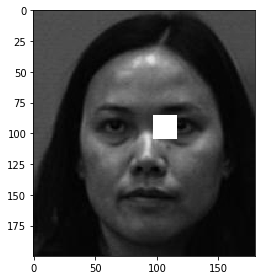

In [ ]:
#Example of occluded face
imshow(train[781])

### Denoising

In [ ]:
# Denosing autoencoder
input_img = Input(shape=(200, 180, 1))

# adam = tf.keras.optimizers.Adam(0.1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 3), padding='same')(x)
flat= Flatten()(encoder)
dnn= Dense(3000)(flat)
dnn= Dense(3000)(dnn)
res= Reshape((25,15,8))(dnn)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(res)
x = UpSampling2D((2, 3))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
history=autoencoder.fit(train, train,
                    epochs=100,
                    batch_size=64, callbacks=[es], shuffle=True)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 200, 180, 1)]     0         
                                                                 
 conv2d_195 (Conv2D)         (None, 200, 180, 8)       80        
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 100, 90, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 100, 90, 8)        584       
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 50, 45, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_197 (Conv2D)         (None, 50, 45, 8)         584

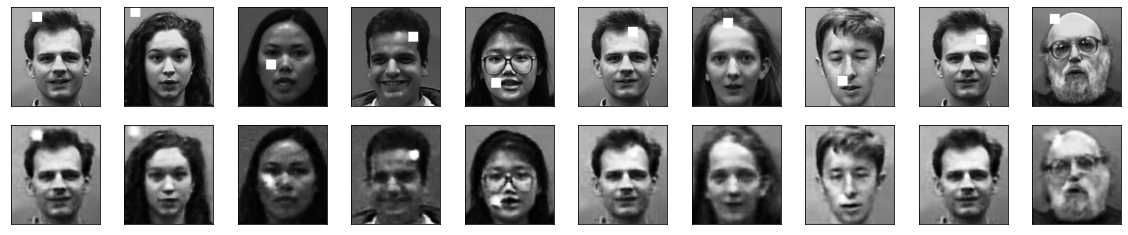

In [ ]:
# The final loss was 0.0018 MSE
decoded_imgs = autoencoder.predict(test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originelen
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructies
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
#Above the result of the original image can be seen, below is the result of the reconstructed image

### Undercomplete

In [ ]:
# Using an undercomplete autoencoder, similair to ones used for anomaly detection
input_img = Input(shape=(200, 180, 1))

# adam = tf.keras.optimizers.Adam(0.1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 3), padding='same')(x)
flat= Flatten()(encoder)
dnn= Dense(3000)(flat)
dnn= Dense(3000)(dnn)
res= Reshape((25,15,8))(dnn)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(res)
x = UpSampling2D((2, 3))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
history=autoencoder.fit(train, train,
                    epochs=100,
                    batch_size=64, callbacks=[es], shuffle=True)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 200, 180, 1)]     0         
                                                                 
 conv2d_209 (Conv2D)         (None, 200, 180, 32)      320       
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 100, 90, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_210 (Conv2D)         (None, 100, 90, 16)       4624      
                                                                 
 max_pooling2d_115 (MaxPooli  (None, 50, 45, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_211 (Conv2D)         (None, 50, 45, 8)         116

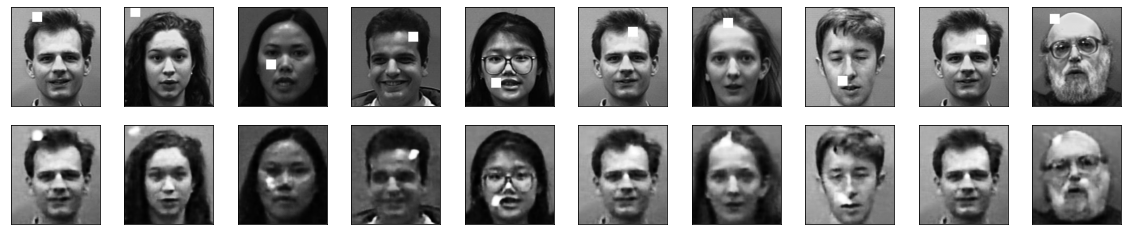

In [ ]:
# The final loss was 0.0015 MSE
decoded_imgs = autoencoder.predict(test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originelen
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructies
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
#Above the result of the original image can be seen, below is the result of the reconstructed image

### Overcomplete

In [ ]:
# Using an overcomplete autoencoder.
input_img = Input(shape=(200, 180, 1))

# adam = tf.keras.optimizers.Adam(0.1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(10, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 3), padding='same')(x)
flat= Flatten()(encoder)
dnn= Dense(3750)(flat)
dnn= Dense(3750)(dnn)
res= Reshape((25,15,10))(dnn)


x = Conv2D(10, (3, 3), activation='relu', padding='same')(res)
x = UpSampling2D((2, 3))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
history=autoencoder.fit(train, train,
                    epochs=100,
                    batch_size=64, callbacks=[es], shuffle=True)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 200, 180, 1)]     0         
                                                                 
 conv2d_246 (Conv2D)         (None, 200, 180, 4)       40        
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 100, 90, 4)       0         
 ng2D)                                                           
                                                                 
 conv2d_247 (Conv2D)         (None, 100, 90, 4)        148       
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 50, 45, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_248 (Conv2D)         (None, 50, 45, 10)        370

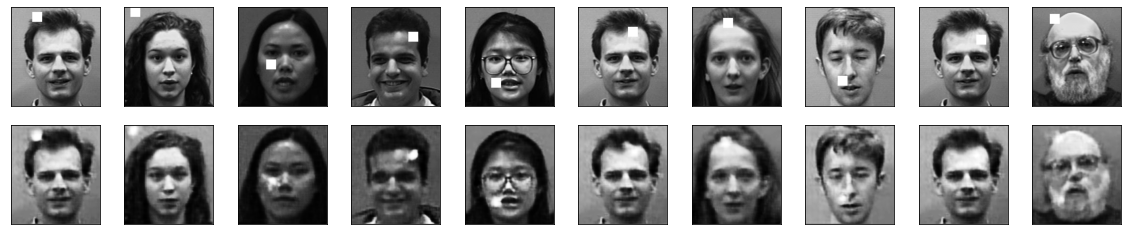

In [ ]:
# The final loss was 0.0016 MSE
decoded_imgs = autoencoder.predict(test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originelen
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructies
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(200, 180))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Based on the loss all 3 of the models are really close, comparing them on sight the undercomplete seems to perform best